In [1]:
import numpy as np
import pandas as pd 

import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10,7

In [2]:
def mad_outlier(y, thresh):
    '''
    compute outliers based on mad
    # args
        y: assumed to be array with shape (N,1)
        thresh: float()
    # returns
        array index of outliers
    '''
    y = np.expand_dims(y, axis=1)
    median = np.median(y)
    diff = np.sum((y - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [3]:
df = pd.read_csv('IVE_tickbidask.txt', delimiter = ",", names = ['date', 'time', 'price', 'bid', 'ask', 'vol'])

In [4]:
mad = mad_outlier(df.price.values, 2.57)

In [5]:
### drop the incorrect rows
check = df.loc[~mad]

In [6]:
df = check
df['Datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
df = df.set_index('Datetime')
df = df.drop(['date','time'], axis=1)
df['dollar_vol'] = df.price * df.vol

In [7]:
from tqdm import tqdm
def dollar_bars(df, dv_column, m):
    '''
    compute dollar bars
    # args
        df: pd.DataFrame()
        column: name for dollar volume data
        m: int(), threshold value for dollars
    # returns
        idx: list of indices
    '''
    t = df[dv_column]
    ts = 0
    idx = []
    for i, x in enumerate(tqdm(t)):
        ts += x
        if ts >= m:
            idx.append(i)
            ts = 0
            continue
    return idx

def dollar_bar_df(df, dv_column, m):
    idx = dollar_bars(df, dv_column, m)
    return df.iloc[idx]

In [8]:
dbars = dollar_bar_df(df, 'dollar_vol', 1_000_000)

100%|██████████| 8662071/8662071 [00:02<00:00, 3197709.27it/s]


In [9]:
dbars

,price,bid,ask,vol,dollar_vol
Datetime,,,,,
2009-09-28 09:46:34,51.07,51.07,51.08,900,45963.00
2009-09-28 09:52:47,51.13,51.13,51.14,2000,102260.00
2009-09-28 09:54:38,51.13,51.12,51.13,2000,102260.00
2009-09-28 09:55:26,51.14,51.14,51.15,100,5114.00
2009-09-28 10:02:48,51.25,51.24,51.25,700,35875.00
...,...,...,...,...,...
2021-02-24 15:57:14,137.87,137.87,137.88,100,13787.00
2021-02-24 15:59:00,137.80,137.80,137.81,100,13780.00
2021-02-24 15:59:15,137.82,137.81,137.82,100,13782.00


In [10]:
def getDailyVol(close,
                span0=100):
    """SNIPPET 3.1 DAILY VOLATILITY ESTIMATES
    Daily vol reindexed to close
    """ 
    df0=close.index.searchsorted(close.index-pd.Timedelta(days=1))
    df0=df0[df0>0]   
    df0=(pd.Series(close.index[df0-1], 
                   index=close.index[close.shape[0]-df0.shape[0]:]))   
    try:
        df0=close.loc[df0.index]/close.loc[df0.values].values-1 # daily rets
    except Exception as e:
        print(f'error: {e}\nplease confirm no duplicate indices')
    df0=df0.ewm(span=span0).std().rename('dailyVol')
    return df0

In [11]:
close = dbars.price.copy()

In [12]:
close = close.drop_duplicates()
close = close[~close.index.duplicated(keep='first')]

In [13]:
dailyVol = getDailyVol(close)

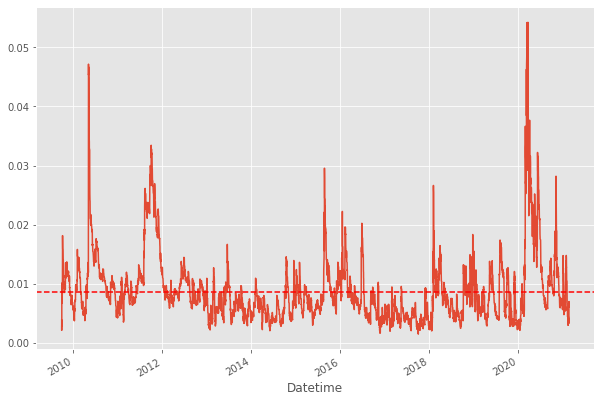

In [14]:
f,ax=plt.subplots()
dailyVol.plot(ax=ax)
ax.axhline(dailyVol.mean(),ls='--',color='r')

In [15]:
def getTEvents(gRaw, h):
    tEvents, sPos, sNeg = [], 0, 0
    diff = np.log(gRaw).diff().dropna()
    for i in tqdm(diff.index[1:]):
        try:
            pos, neg = float(sPos+diff.loc[i]), float(sNeg+diff.loc[i])
        except Exception as e:
            print(e)
            print(sPos+diff.loc[i], type(sPos+diff.loc[i]))
            print(sNeg+diff.loc[i], type(sNeg+diff.loc[i]))
            break
        sPos, sNeg=max(0., pos), min(0., neg)
        if sNeg<-h:
            sNeg=0;tEvents.append(i)
        elif sPos>h:
            sPos=0;tEvents.append(i)
    return pd.DatetimeIndex(tEvents)

In [16]:
tEvents = getTEvents(close, h=dailyVol.mean())
tEvents

100%|██████████| 37856/37856 [00:01<00:00, 29361.11it/s]


DatetimeIndex(['2009-09-29 09:29:56', '2009-09-30 09:52:49',
               '2009-09-30 13:48:55', '2009-09-30 15:17:21',
               '2009-10-01 10:00:04', '2009-10-01 11:16:04',
               '2009-10-01 15:56:29', '2009-10-02 09:31:33',
               '2009-10-02 10:34:22', '2009-10-05 10:24:13',
               ...
               '2021-02-05 09:30:49', '2021-02-08 14:49:07',
               '2021-02-10 09:30:00', '2021-02-11 12:27:11',
               '2021-02-12 15:51:56', '2021-02-19 10:01:46',
               '2021-02-22 12:39:59', '2021-02-23 15:10:40',
               '2021-02-24 10:46:07', '2021-02-24 14:00:02'],
              dtype='datetime64[ns]', length=2553, freq=None)

In [17]:
def addVerticalBarrier(tEvents, close, numDays=1):
    t1=close.index.searchsorted(tEvents+pd.Timedelta(days=numDays))
    t1=t1[t1<close.shape[0]]
    t1=(pd.Series(close.index[t1],index=tEvents[:t1.shape[0]]))
    return t1

In [18]:
t1 = addVerticalBarrier(tEvents, close, numDays=1)
t1

2009-09-29 09:29:56   2009-09-30 09:35:10
2009-09-30 09:52:49   2009-10-01 10:00:04
2009-09-30 13:48:55   2009-10-01 14:13:34
2009-09-30 15:17:21   2009-10-01 15:29:56
2009-10-01 10:00:04   2009-10-02 10:01:56
                              ...        
2021-02-11 12:27:11   2021-02-12 12:43:20
2021-02-12 15:51:56   2021-02-16 09:30:00
2021-02-19 10:01:46   2021-02-22 09:39:39
2021-02-22 12:39:59   2021-02-23 12:47:28
2021-02-23 15:10:40   2021-02-24 15:13:13
Name: Datetime, Length: 2551, dtype: datetime64[ns]

In [19]:
def getEvents(close, tEvents, ptSl, trgt, minRet, numThreads, t1=False, side=None):
    #1) get target
    trgt=trgt.loc[trgt.index.intersection(tEvents)]
    trgt=trgt[trgt>minRet] # minRet
    #2) get t1 (max holding period)
    if t1 is False:t1=pd.Series(pd.NaT, index=tEvents)
    #3) form events object, apply stop loss on t1
    if side is None:side_,ptSl_=pd.Series(1.,index=trgt.index), [ptSl[0],ptSl[0]]
    else: side_,ptSl_=side.loc[side.index.intersection(trgt.index)],ptSl[:2]
    events=(pd.concat({'t1':t1,'trgt':trgt,'side':side_}, axis=1)
            .dropna(subset=['trgt']))
    df0=mpPandasObj(func=applyPtSlOnT1,pdObj=('molecule',events.index),
                    numThreads=numThreads,close=close,events=events,
                    ptSl=ptSl_)
    events['t1']=df0.dropna(how='all').min(axis=1) # pd.min ignores nan
    if side is None:events=events.drop('side',axis=1)
    return events

In [20]:
def mpPandasObj(func,pdObj,numThreads=24,mpBatches=1,linMols=True,**kargs):
    '''
    Parallelize jobs, return a dataframe or series
    + func: function to be parallelized. Returns a DataFrame
    + pdObj[0]: Name of argument used to pass the molecule
    + pdObj[1]: List of atoms that will be grouped into molecules
    + kwds: any other argument needed by func
    
    Example: df1=mpPandasObj(func,('molecule',df0.index),24,**kwds)
    '''
    import pandas as pd
    #if linMols:parts=linParts(len(argList[1]),numThreads*mpBatches)
    #else:parts=nestedParts(len(argList[1]),numThreads*mpBatches)
    if linMols:parts=linParts(len(pdObj[1]),numThreads*mpBatches)
    else:parts=nestedParts(len(pdObj[1]),numThreads*mpBatches)
    
    jobs=[]
    for i in range(1,len(parts)):
        job={pdObj[0]:pdObj[1][parts[i-1]:parts[i]],'func':func}
        job.update(kargs)
        jobs.append(job)
    if numThreads==1:out=processJobs_(jobs)
    else: out=processJobs(jobs,numThreads=numThreads)
    if isinstance(out[0],pd.DataFrame):df0=pd.DataFrame()
    elif isinstance(out[0],pd.Series):df0=pd.Series()
    else:return out
    for i in out:df0=df0.append(i)
    df0=df0.sort_index()
    return df0

In [21]:
def applyPtSlOnT1(close,events,ptSl,molecule):
    # apply stop loss/profit taking, if it takes place before t1 (end of event)
    events_=events.loc[molecule]
    out=events_[['t1']].copy(deep=True)
    if ptSl[0]>0: pt=ptSl[0]*events_['trgt']
    else: pt=pd.Series(index=events.index) # NaNs
    if ptSl[1]>0: sl=-ptSl[1]*events_['trgt']
    else: sl=pd.Series(index=events.index) # NaNs
    for loc,t1 in events_['t1'].fillna(close.index[-1]).iteritems():
        df0=close[loc:t1] # path prices
        df0=(df0/close[loc]-1)*events_.at[loc,'side'] # path returns
        out.loc[loc,'sl']=df0[df0<sl[loc]].index.min() # earliest stop loss
        out.loc[loc,'pt']=df0[df0>pt[loc]].index.min() # earliest profit taking
    return out

In [22]:
def linParts(numAtoms,numThreads):
    # partition of atoms with a single loop
    parts=np.linspace(0,numAtoms,min(numThreads,numAtoms)+1)
    parts=np.ceil(parts).astype(int)
    return parts

In [23]:
def processJobs_(jobs):
    # Run jobs sequentially, for debugging
    out=[]
    for job in jobs:
        out_=expandCall(job)
        out.append(out_)
    return out

In [24]:
def expandCall(kargs):
    # Expand the arguments of a callback function, kargs['func']
    func=kargs['func']
    del kargs['func']
    out=func(**kargs)
    return out

In [35]:
# create target series
ptsl = [1,1]
target = dailyVol
# select minRet
minRet = 0.005

# Run in single-threaded mode on Windows
import platform
if platform.system() == "Windows":
    cpus = 1
else:
    cpus = cpu_count() - 1
    
events = getEvents(close,tEvents,ptsl,target,minRet,cpus,t1=t1)

In [36]:
events

,t1,trgt
2009-09-30 09:52:49,2009-09-30 13:48:55,0.005835
2009-09-30 13:48:55,2009-10-01 09:40:10,0.008611
2009-09-30 15:17:21,2009-10-01 10:10:13,0.008345
2009-10-01 10:00:04,2009-10-01 11:16:04,0.007844
2009-10-01 11:16:04,2009-10-01 15:56:29,0.006742
...,...,...
2021-02-05 09:30:49,2021-02-08 09:46:21,0.012326
2021-02-08 14:49:07,2021-02-09 14:49:39,0.009205
2021-02-10 09:30:00,2021-02-10 10:42:55,0.006796
2021-02-11 12:27:11,2021-02-12 09:53:01,0.005516


In [37]:
def mpNumCoEvents(closeIdx,t1,molecule):
    '''
    Compute the number of concurrent events per bar.
    +molecule[0] is the date of the first event on which the weight will be computed
    +molecule[-1] is the date of the last event on which the weight will be computed
    
    Any event that starts before t1[modelcule].max() impacts the count.
    '''
    #1) find events that span the period [molecule[0],molecule[-1]]
    t1=t1.fillna(closeIdx[-1]) # unclosed events still must impact other weights
    t1=t1[t1>=molecule[0]] # events that end at or after molecule[0]
    t1=t1.loc[:t1[molecule].max()] # events that start at or before t1[molecule].max()
    #2) count events spanning a bar
    iloc=closeIdx.searchsorted(np.array([t1.index[0],t1.max()]))
    count=pd.Series(0,index=closeIdx[iloc[0]:iloc[1]+1])
    for tIn,tOut in t1.iteritems():count.loc[tIn:tOut]+=1.
    return count.loc[molecule[0]:t1[molecule].max()]

In [38]:
def mpSampleW(t1,numCoEvents,close,molecule):
    # Derive sample weight by return attribution
    ret=np.log(close).diff() # log-returns, so that they are additive
    wght=pd.Series(index=molecule)
    for tIn,tOut in t1.loc[wght.index].iteritems():
        wght.loc[tIn]=(ret.loc[tIn:tOut]/numCoEvents.loc[tIn:tOut]).sum()
    return wght.abs()

In [39]:
def mpSampleTW(t1,numCoEvents,molecule):
    # Derive avg. uniqueness over the events lifespan
    wght=pd.Series(index=molecule)
    for tIn,tOut in t1.loc[wght.index].iteritems():
        wght.loc[tIn]=(1./numCoEvents.loc[tIn:tOut]).mean()
    return wght

In [40]:
## Example
numCoEvents = mpPandasObj(mpNumCoEvents,('molecule',events.index),                         
                              cpus,closeIdx=close.index,t1=events['t1'])
numCoEvents = numCoEvents.loc[~numCoEvents.index.duplicated(keep='last')]
numCoEvents = numCoEvents.reindex(close.index).fillna(0)
out=pd.DataFrame()
out['tW'] = mpPandasObj(mpSampleTW,('molecule',events.index),
                            cpus,t1=events['t1'],numCoEvents=numCoEvents)
## example ##
out['w']=mpPandasObj(mpSampleW,('molecule',events.index),cpus,
                         t1=events['t1'],numCoEvents=numCoEvents,close=close)
out['w']*=out.shape[0]/out['w'].sum()

C:\Users\alane\Anaconda3\envs\wahoo\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\alane\Anaconda3\envs\wahoo\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\alane\Anaconda3\envs\wahoo\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


C:\Users\alane\Anaconda3\envs\wahoo\lib\site-packages\pandas\plotting\_matplotlib\__init__.py:61: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


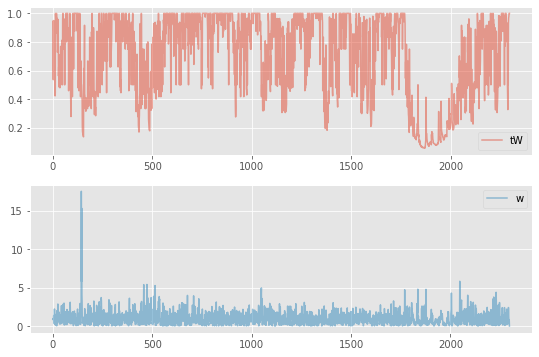

In [41]:
fig, ax = plt.subplots(figsize=(9,6))
out.reset_index(drop=True).plot(subplots=True, alpha=0.5, ax=ax);

In [43]:
def returns(s):
    arr = np.diff(np.log(s))
    return (pd.Series(arr, index=s.index[1:]))

In [45]:
coEvents_std = (
    pd.DataFrame()
    .assign(
        numCoEvents = numCoEvents.reset_index(drop=True),
        std = returns(dbars.price).ewm(50).std().reset_index(drop=True))
)

<AxesSubplot:label='f30cd1a7-2e1e-44af-893c-564eb71ae76c'>

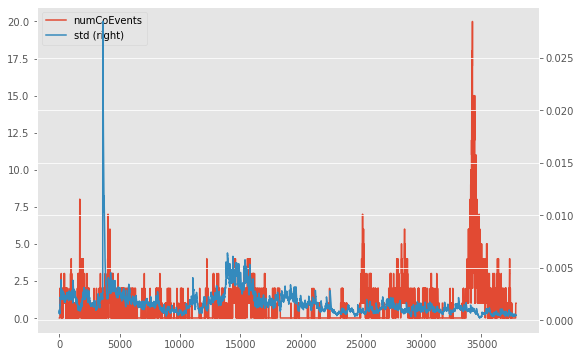

In [46]:
fig, ax = plt.subplots(figsize=(9,6))

coEvents_std.numCoEvents.plot(legend=True, ax=ax)
coEvents_std['std'].plot(secondary_y=True, legend=True, ax=ax)

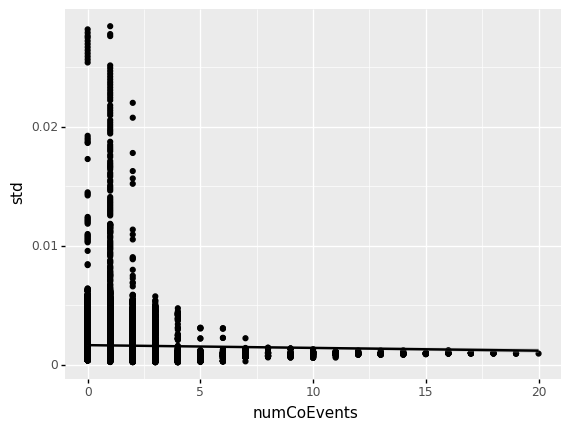

<ggplot: (-9223371868253061352)>

In [49]:
import warnings
import plotnine as pn
warnings.filterwarnings("ignore")

(pn.ggplot(coEvents_std, pn.aes('numCoEvents', 'std'))
 +pn.geom_point()
 +pn.stat_smooth())

In [50]:
lag = 1
lag_col = f'tW_lag_{lag}'
out[lag_col] = out['tW'].shift(lag)

In [55]:
import pymc3 as pm
with pm.Model() as mdl:
    pm.GLM.from_formula(f'tW ~ {lag_col}', out.dropna())
    trace = pm.sample(3000, cores=1, target_accept = 0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, tW_lag_1, Intercept]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 9882 seconds.


In [56]:
plt.figure(figsize=(9, 6))
plot_traces(trace, retain=1_000)
plt.tight_layout();

NameError: name 'plot_traces' is not defined

<Figure size 648x432 with 0 Axes>

In [59]:
df_smry = pm.summary(trace[1000:])
df_smry

AttributeError: module 'pymc3' has no attribute 'summary'

In [61]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

Xy = (pd.DataFrame()
      .assign(close=close,
              close_lag=close.shift(1))
     ).dropna()

y = Xy.loc[:,'close'].values
X = Xy.loc[:,'close_lag'].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    shuffle=False)

n_estimator = 50
rf = RandomForestRegressor(max_depth=1, n_estimators=n_estimator,
                           criterion='mse', oob_score=True,
                           random_state=777)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=1, n_estimators=50, oob_score=True,
                      random_state=777)

In [62]:
rf.oob_score_

0.7358512887375233

In [64]:
from sklearn.model_selection import cross_validate

n_estimator = 50
rf = RandomForestRegressor(max_depth=1, n_estimators=n_estimator,
                           criterion='mse', oob_score=True,
                           random_state=777)

scores = cross_validate(rf, X, y, cv=5, return_estimator=True)

In [65]:
oob_scores = [est.oob_score_ for est in scores['estimator']]
oob_scores, np.mean(oob_scores)

([0.7115124206415762,
  0.8002141518010881,
  0.7540257142421563,
  0.6687917251086071,
  0.7399198022141751],
 0.7348927628015206)

In [66]:
def getExTimeDecay(tW,clfLastW=1.,exponent=1):
    # apply exponential decay to observed uniqueness (tW)
    # newest observation gets weight=1, oldest observation gets weight=clfLastW
    clfW=tW.sort_index().cumsum()
    if clfLastW>=0: slope=((1.-clfLastW)/clfW.iloc[-1])**exponent
    else: slope=(1./((clfLastW+1)*clfW.iloc[-1]))**exponent
    const=1.-slope*clfW.iloc[-1]
    clfW=const+slope*clfW
    clfW[clfW<0]=0
    print(round(const,4), round(slope,4))
    return clfW

1.0 0.0
-1.2431 0.0014
-2.7724 0.0023
-5.3444 0.0039
-6.8722 0.0049
-9.67 0.0066


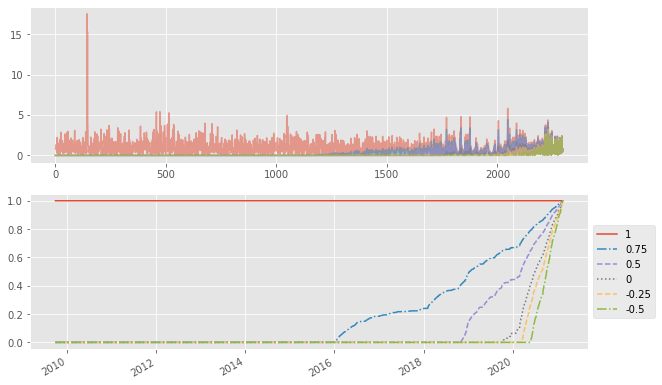

In [67]:
f,ax=plt.subplots(2,figsize=(10,7))
fs = [1,.75,.5,0,-.25,-.5]
ls = ['-','-.','--',':','--','-.']
for lstW, l in zip(fs,ls):
    decayFactor = getExTimeDecay(out['tW'].dropna(), 
                                 clfLastW=lstW,
                                 exponent=0.75) # experiment by changing exponent
    ((out['w'].dropna()*decayFactor).reset_index(drop=True)
     .plot(ax=ax[0],alpha=0.5))
    s = (pd.Series(1,index=out['w'].dropna().index)*decayFactor)
    s.plot(ax=ax[1], ls=l, label=str(lstW))
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))